<a href="https://colab.research.google.com/github/igorz999/Sentiment-analysis/blob/main/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, BertModel

import torch
import torch.nn as nn

import torch
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report

In [5]:
!pip install kaggle


In [ ]:
#reviews = pd.read_csv('/home/anja/Desktop/RI/Sentiment-analysis/data/imdb.csv')

In [6]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import io

reviews = pd.read_csv(io.BytesIO(uploaded['imdb.csv']))


Saving imdb.csv to imdb.csv


In [7]:
len(reviews)


50000

In [8]:
reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [9]:
reviews = reviews.drop_duplicates()

In [10]:
reviews.shape

(49582, 2)

In [11]:
reviews['sentiment'] = reviews['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

<ipython-input-11-15a319623c3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['sentiment'] = reviews['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)


In [12]:
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


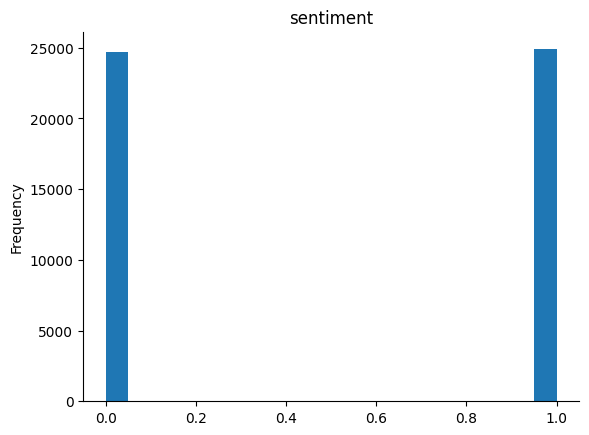

In [13]:
from matplotlib import pyplot as plt
reviews['sentiment'].plot(kind='hist', bins=20, title='sentiment')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
class Tokenize_dataset:
  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text.reset_index(drop=True)
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.targets = targets.reset_index(drop=True)

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, item):
    text = str(self.text[item])
    targets = self.targets[item]
    inputs = self.tokenizer.encode_plus(
        str(text),
        add_special_tokens = True,
        max_length = self.max_len,
        padding='max_length',
        truncation=True
    )

    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    token_type_ids = inputs.get("token_type_ids", [0] * len(ids))

    return {
        "ids": torch.tensor(ids, dtype=torch.long),
        "mask": torch.tensor(mask, dtype=torch.long),
        "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
        "targets": torch.tensor(targets, dtype=torch.long)
    }

In [15]:
train_maxlen = 80
batch_size = 32
epochs = 3
bert_model = 'huawei-noah/TinyBERT_General_4L_312D'
learning_rate = 3e-5

In [16]:
class CompleteModel(nn.Module):
    def __init__(self, bert):
        super(CompleteModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert)
        self.drop = nn.Dropout(p=0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, 2)  # Number of output classes = 2 (positive, negative)

    def forward(self, ids, mask, token_type_ids):
        _, pooled_output = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        output = self.drop(pooled_output)
        return self.out(output)

In [17]:
X = reviews['review']
y = reviews['sentiment']

y.shape

(49582,)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [20]:
tokenizer = AutoTokenizer.from_pretrained(bert_model) # dal treba BertTokenizer?

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
train_dataset = Tokenize_dataset(X_train, y_train, tokenizer, max_len=train_maxlen)
val_dataset = Tokenize_dataset(X_val, y_val, tokenizer, max_len=train_maxlen)
test_dataset = Tokenize_dataset(X_test, y_test, tokenizer, max_len=train_maxlen)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
model = CompleteModel(bert_model)

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

In [24]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training process
Epoch 1/3 - Training
Completed 0 batches
Completed 50 batches
Completed 100 batches
Completed 150 batches
Completed 200 batches
Completed 250 batches
Completed 300 batches
Completed 350 batches
Completed 400 batches
Completed 450 batches
Completed 500 batches
Completed 550 batches
Completed 600 batches
Completed 650 batches
Completed 700 batches
Completed 750 batches
Completed 800 batches
Completed 850 batches
Completed 900 batches
Completed 950 batches
Completed 1000 batches
Completed 1050 batches
Completed 1100 batches
Entering evaluation
Epoch 1/3, Validation Loss: 0.3895441070199013, Accuracy: 0.825560877237207
Epoch 2/3 - Training
Completed 0 batches
Completed 50 batches
Completed 100 batches
Completed 150 batches
Completed 200 batches
Completed 250 batches
Completed 300 batches
Completed 350 batches
Completed 400 batches
Completed 450 batches
Completed 500 batches
Completed 550 batches
Completed 600 batches
Completed 650 batches
Completed 700 batches
Com

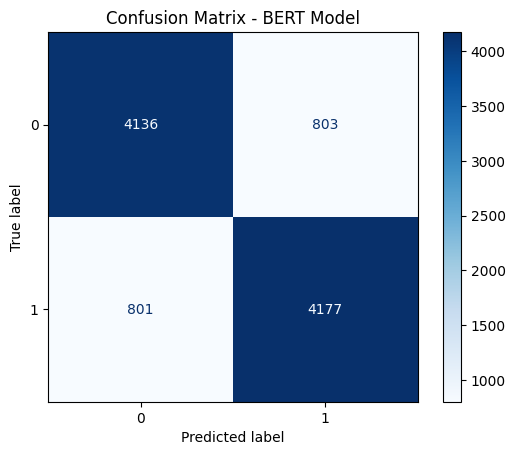

In [25]:
# Training loop
print("Starting training process")
for epoch in range(epochs):
    model.train()
    print(f"Epoch {epoch+1}/{epochs} - Training")
    i = 0
    for batch in train_loader:
        ids = batch['ids']
        mask = batch['mask']
        token_type_ids = batch['token_type_ids']
        targets = batch['targets']

        optimizer.zero_grad()
        outputs = model(ids, mask, token_type_ids)  # Expecting only one value returned
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print(f"Completed {i} batches")
        i += 1

    # Validation loop
    model.eval()
    print("Entering evaluation")
    val_loss = 0
    correct_preds = 0
    with torch.no_grad():
        for batch in val_loader:
            ids = batch['ids']
            mask = batch['mask']
            token_type_ids = batch['token_type_ids']
            targets = batch['targets']

            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_preds += (preds == targets).sum().item()

    print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss/len(val_loader)}, Accuracy: {correct_preds/len(val_dataset)}')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Test loop
print("Testing the model")
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        ids = batch['ids']
        mask = batch['mask']
        token_type_ids = batch['token_type_ids']
        targets = batch['targets']

        outputs = model(ids, mask, token_type_ids)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - BERT Model')
plt.show()

